# Model Selection

## Objective - To predict 4D results with the best model

In [1]:
# Import the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix , classification_report, f1_score,\
                            accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

SEED = 0

### Step 1: Load in the required data

In [2]:
# Concatenate 3 CSV files from web scraping

df = pd.concat(
    map(pd.read_csv, ['webscraping1.csv', 'webscraping2.csv', 'webscraping3.csv']), ignore_index=True)
df.head(10)

,day,number,prize
0,"Wed, 24 Jun 2020",0,Consolation Prize
1,"Sun, 21 Feb 2016",0,Consolation Prize
2,"Wed, 20 Jan 2016",0,Consolation Prize
3,"Sun, 05 Oct 2014",0,First Prize
4,"Sat, 06 Sep 2014",0,Second Prize
5,"Sat, 26 Oct 2013",0,Starter Prize
6,"Sun, 29 Jan 2012",0,Starter Prize
7,"Sat, 06 Aug 2011",0,Consolation Prize
8,"Sat, 13 Jun 2009",0,Consolation Prize
9,"Sun, 14 May 2006",0,Starter Prize


### Step 2: Data Pre-processing and Exploratory Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110339 entries, 0 to 110338
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   day     110339 non-null  object
 1   number  110339 non-null  int64 
 2   prize   110339 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.5+ MB


In [4]:
# Convert the 'number' column from numeric to fixed length string type (i.e. 4 digits)

df['number'] = df['number'].map('{0:04d}'.format)
df.head(10)

,day,number,prize
0,"Wed, 24 Jun 2020",0000,Consolation Prize
1,"Sun, 21 Feb 2016",0000,Consolation Prize
2,"Wed, 20 Jan 2016",0000,Consolation Prize
3,"Sun, 05 Oct 2014",0000,First Prize
4,"Sat, 06 Sep 2014",0000,Second Prize
5,"Sat, 26 Oct 2013",0000,Starter Prize
6,"Sun, 29 Jan 2012",0000,Starter Prize
7,"Sat, 06 Aug 2011",0000,Consolation Prize
8,"Sat, 13 Jun 2009",0000,Consolation Prize
9,"Sun, 14 May 2006",0000,Starter Prize


In [5]:
# Confirm 10,000 numbers in total

df['number'].nunique()

10000

In [6]:
# Split the 'day' column as 'day of week' and 'date' columns

df[['day_of_week', 'date']] = df['day'].str.split(', ', expand=True)
df.head(10)

,day,number,prize,day_of_week,date
0,"Wed, 24 Jun 2020",0000,Consolation Prize,Wed,24 Jun 2020
1,"Sun, 21 Feb 2016",0000,Consolation Prize,Sun,21 Feb 2016
2,"Wed, 20 Jan 2016",0000,Consolation Prize,Wed,20 Jan 2016
3,"Sun, 05 Oct 2014",0000,First Prize,Sun,05 Oct 2014
4,"Sat, 06 Sep 2014",0000,Second Prize,Sat,06 Sep 2014
5,"Sat, 26 Oct 2013",0000,Starter Prize,Sat,26 Oct 2013
6,"Sun, 29 Jan 2012",0000,Starter Prize,Sun,29 Jan 2012
7,"Sat, 06 Aug 2011",0000,Consolation Prize,Sat,06 Aug 2011
8,"Sat, 13 Jun 2009",0000,Consolation Prize,Sat,13 Jun 2009
9,"Sun, 14 May 2006",0000,Starter Prize,Sun,14 May 2006


In [7]:
# Convert the 'date' column to datetime

df['date'] = pd.to_datetime(df['date'])
df.head(10)

,day,number,prize,day_of_week,date
0,"Wed, 24 Jun 2020",0000,Consolation Prize,Wed,2020-06-24
1,"Sun, 21 Feb 2016",0000,Consolation Prize,Sun,2016-02-21
2,"Wed, 20 Jan 2016",0000,Consolation Prize,Wed,2016-01-20
3,"Sun, 05 Oct 2014",0000,First Prize,Sun,2014-10-05
4,"Sat, 06 Sep 2014",0000,Second Prize,Sat,2014-09-06
5,"Sat, 26 Oct 2013",0000,Starter Prize,Sat,2013-10-26
6,"Sun, 29 Jan 2012",0000,Starter Prize,Sun,2012-01-29
7,"Sat, 06 Aug 2011",0000,Consolation Prize,Sat,2011-08-06
8,"Sat, 13 Jun 2009",0000,Consolation Prize,Sat,2009-06-13
9,"Sun, 14 May 2006",0000,Starter Prize,Sun,2006-05-14


In [8]:
# Filter the 'date' column to remove data on 2021-6-6 due to partial scraping on that day

df = df[(df['date'] < '2021-6-6')]
df.count()

day            110322
number         110322
prize          110322
day_of_week    110322
date           110322
dtype: int64

In [9]:
# Return counts of unique days of week
# Only 1 draw on Thu, 25 Jan 2001, which replaced the draw on Wed, 24 Jan 2001
# Less draws on Wed (first draw in 1993) than Sat and Sun (first draws in 1986)

df['day_of_week'].value_counts()

Sat    41783
Sun    41744
Wed    26772
Thu       23
Name: day_of_week, dtype: int64

In [10]:
# Replace 'Thu' with 'Wed'

df['day_of_week'].replace({'Thu': 'Wed'}, inplace=True)
df['day_of_week'].value_counts()

Sat    41783
Sun    41744
Wed    26795
Name: day_of_week, dtype: int64

In [11]:
# Convert the 'date' column to the month abbreviated name format under 'month' column

df['month'] = df['date'].dt.strftime('%b')
df.head(10)

,day,number,prize,day_of_week,date,month
0,"Wed, 24 Jun 2020",0000,Consolation Prize,Wed,2020-06-24,Jun
1,"Sun, 21 Feb 2016",0000,Consolation Prize,Sun,2016-02-21,Feb
2,"Wed, 20 Jan 2016",0000,Consolation Prize,Wed,2016-01-20,Jan
3,"Sun, 05 Oct 2014",0000,First Prize,Sun,2014-10-05,Oct
4,"Sat, 06 Sep 2014",0000,Second Prize,Sat,2014-09-06,Sep
5,"Sat, 26 Oct 2013",0000,Starter Prize,Sat,2013-10-26,Oct
6,"Sun, 29 Jan 2012",0000,Starter Prize,Sun,2012-01-29,Jan
7,"Sat, 06 Aug 2011",0000,Consolation Prize,Sat,2011-08-06,Aug
8,"Sat, 13 Jun 2009",0000,Consolation Prize,Sat,2009-06-13,Jun
9,"Sun, 14 May 2006",0000,Starter Prize,Sun,2006-05-14,May


In [12]:
# Drop the redundant columns

df = df.drop(['day', 'date'], axis=1)
df.head(10)

,number,prize,day_of_week,month
0,0000,Consolation Prize,Wed,Jun
1,0000,Consolation Prize,Sun,Feb
2,0000,Consolation Prize,Wed,Jan
3,0000,First Prize,Sun,Oct
4,0000,Second Prize,Sat,Sep
5,0000,Starter Prize,Sat,Oct
6,0000,Starter Prize,Sun,Jan
7,0000,Consolation Prize,Sat,Aug
8,0000,Consolation Prize,Sat,Jun
9,0000,Starter Prize,Sun,May


In [13]:
# Return counts of unique numbers

new_list = df['number'].value_counts().sort_values(ascending=True)
new_list.head(20)

6190    1
7705    2
6959    2
0057    2
2982    2
6212    2
8293    2
5675    2
6061    2
7901    2
2648    3
0350    3
0679    3
0849    3
7147    3
6245    3
4543    3
1229    3
7669    3
1563    3
Name: number, dtype: int64

In [14]:
df.isna().any()

number         False
prize          False
day_of_week    False
month          False
dtype: bool

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110322 entries, 0 to 110338
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   number       110322 non-null  object
 1   prize        110322 non-null  object
 2   day_of_week  110322 non-null  object
 3   month        110322 non-null  object
dtypes: object(4)
memory usage: 4.2+ MB


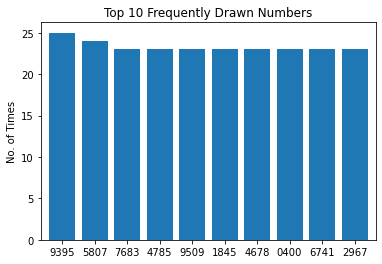

In [16]:
s = df['number'].value_counts().nlargest(10)
s.plot(kind='bar', width = 0.8, rot=0)

plt.ylabel("No. of Times")
plt.title("Top 10 Frequently Drawn Numbers")
plt.show()

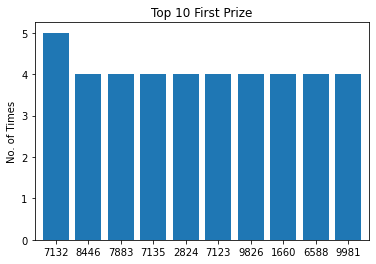

In [17]:
t = df[df['prize'].isin(['First Prize'])]

s = t['number'].value_counts().nlargest(10)
s.plot(kind='bar', width = 0.8, rot=0)

plt.ylabel("No. of Times")
plt.title("Top 10 First Prize")
plt.show()

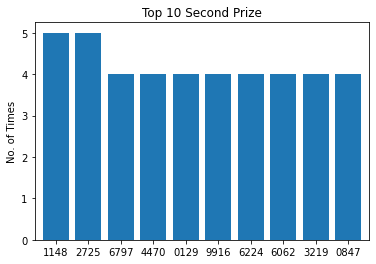

In [18]:
t = df[df['prize'].isin(['Second Prize'])]

s = t['number'].value_counts().nlargest(10)
s.plot(kind='bar', width = 0.8, rot=0)

plt.ylabel("No. of Times")
plt.title("Top 10 Second Prize")
plt.show()

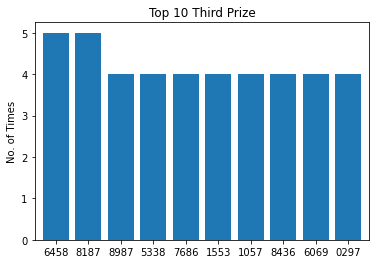

In [19]:
t = df[df['prize'].isin(['Third Prize'])]

s = t['number'].value_counts().nlargest(10)
s.plot(kind='bar', width = 0.8, rot=0)

plt.ylabel("No. of Times")
plt.title("Top 10 Third Prize")
plt.show()

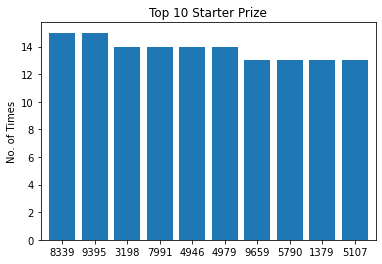

In [20]:
t = df[df['prize'].isin(['Starter Prize'])]

s = t['number'].value_counts().nlargest(10)
s.plot(kind='bar', width = 0.8, rot=0)

plt.ylabel("No. of Times")
plt.title("Top 10 Starter Prize")
plt.show()

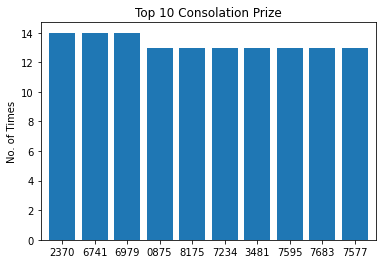

In [21]:
t = df[df['prize'].isin(['Consolation Prize'])]

s = t['number'].value_counts().nlargest(10)
s.plot(kind='bar', width = 0.8, rot=0)

plt.ylabel("No. of Times")
plt.title("Top 10 Consolation Prize")
plt.show()

In [22]:
# Encode variables with more than 2 Classes

df = pd.get_dummies(df, columns= ['prize', 'day_of_week', 'month'])

In [23]:
# Convert 'number' from string to numeric type

df['number'] = pd.to_numeric(df['number'])

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110322 entries, 0 to 110338
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype
---  ------                   --------------   -----
 0   number                   110322 non-null  int64
 1   prize_Consolation Prize  110322 non-null  uint8
 2   prize_First Prize        110322 non-null  uint8
 3   prize_Second Prize       110322 non-null  uint8
 4   prize_Starter Prize      110322 non-null  uint8
 5   prize_Third Prize        110322 non-null  uint8
 6   day_of_week_Sat          110322 non-null  uint8
 7   day_of_week_Sun          110322 non-null  uint8
 8   day_of_week_Wed          110322 non-null  uint8
 9   month_Apr                110322 non-null  uint8
 10  month_Aug                110322 non-null  uint8
 11  month_Dec                110322 non-null  uint8
 12  month_Feb                110322 non-null  uint8
 13  month_Jan                110322 non-null  uint8
 14  month_Jul                110322 non-

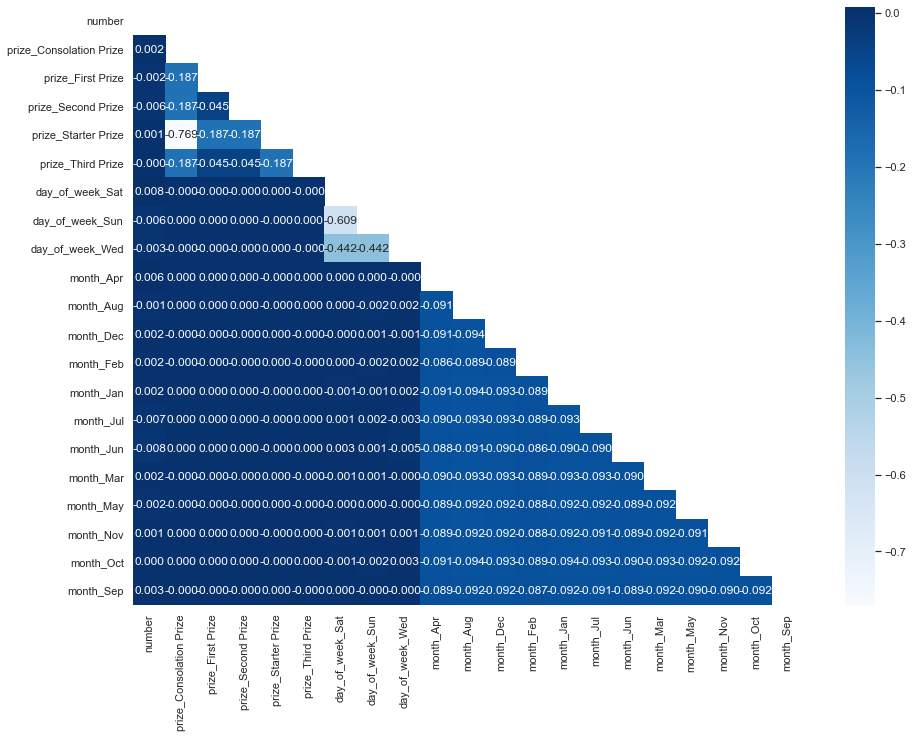

In [25]:
# Correlation matrix

sns.set(style="white")

matrix = np.triu(df.corr())

fig, ax = plt.subplots(figsize=(15,11))

_ = sns.heatmap(df.corr(), mask=matrix, cmap='Blues', annot=True, fmt=".3f")

In [26]:
# Drop first column after performing One Hot Encoding to get k-1 dummies out of k categorical levels

df = df.drop(['prize_Consolation Prize', 'day_of_week_Sat', 'month_Apr'], axis=1)

### Step 3: Split the data and train the models

In [27]:
X=df.drop('number',axis=1)
y=df['number']

# Split the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = SEED)

#### Feature scaling

In [28]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit only to the training data
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

# Now apply the transformations to the data:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Baseline model using Logistic Regression

In [29]:
logreg = LogisticRegression()

In [30]:
%%time
# K-fold cross validation using F1-score as scorer
scores = cross_val_score(logreg, 
                         X_train_scaled, 
                         y_train, 
                         cv=5, 
                         scoring='f1_macro')
print('F1 scores:', scores)
print('Mean & standard deviation: {:.2} {:.2f}'.format(scores.mean(), np.std(scores)))

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\IPython\core\magics\execution.py", line 1321, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 2, in <module>
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 72, in inner_f
    return f(**kwargs)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 401, in cross_val_score
    cv_results = cross_validate(estimator=estimator, X=X, y=y, groups=groups,
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 72, in inner_f
    return f(**kwargs)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 242, in cross_validate
    scores = parallel(
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\user\anaconda3\lib\site-packages\joblib\parallel

TypeError: object of type 'NoneType' has no len()